# 🎯 LSTM 주가 방향성 예측 모델
## 뉴스 감정 + 트위터 감정 + 주가 기술적 지표를 활용한 종합 예측 시스템

### 목표: 미래 주가 방향성을 pos(상승)/neu(유지)/neg(하락)으로 예측

**단계별 구현:**
1. 데이터 통합 및 전처리
2. 특성 공학 (Feature Engineering)  
3. 타겟 변수 생성
4. LSTM 모델 구축
5. 학습 및 평가
6. 결과 분석


In [1]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 딥러닝 라이브러리
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# 전처리 및 평가 라이브러리  
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

print("📚 라이브러리 로드 완료!")
print(f"TensorFlow 버전: {tf.__version__}")
print(f"GPU 사용 가능: {tf.config.list_physical_devices('GPU')}")


📚 라이브러리 로드 완료!
TensorFlow 버전: 2.13.0
GPU 사용 가능: []


## 📊 1단계: 데이터 로드 및 전처리


In [30]:
# 1-1. 주가 데이터 로드 (AAPL)
print("📈 주가 데이터 로드 중...")
stock_df = pd.read_csv('../stock/AAPL_1hour_data_365days.csv')

# Datetime 컬럼에서 +00:00 제거 (요구사항 1)
stock_df['Datetime'] = pd.to_datetime(stock_df['Datetime']).dt.strftime('%Y-%m-%d %H:%M:%S')
stock_df['Datetime'] = pd.to_datetime(stock_df['Datetime'])

print(f"✅ 주가 데이터: {len(stock_df):,}개 행")
print(f"📅 기간: {stock_df['Datetime'].min()} ~ {stock_df['Datetime'].max()}")
print(f"📋 컬럼: {list(stock_df.columns)}")
print("\n주가 데이터 미리보기:")
stock_df.head()


📈 주가 데이터 로드 중...
✅ 주가 데이터: 3,889개 행
📅 기간: 2024-06-17 08:00:00 ~ 2025-06-13 23:00:00
📋 컬럼: ['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Log_Returns', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'Volatility_10', 'Volatility_20', 'Price_Change', 'Price_Change_Pct', 'HL_Spread', 'HL_Spread_Pct', 'Hour', 'DayOfWeek', 'Month', 'Quarter', 'Is_Trading_Hours', 'Is_Market_Open', 'Is_Premarket', 'Is_Aftermarket', 'Is_Extended_Hours']

주가 데이터 미리보기:


,Datetime,Close,High,Low,Open,Volume,Returns,Log_Returns,SMA_10,SMA_20,...,HL_Spread_Pct,Hour,DayOfWeek,Month,Quarter,Is_Trading_Hours,Is_Market_Open,Is_Premarket,Is_Aftermarket,Is_Extended_Hours
0,2024-06-17 08:00:00,214.350,214.36,212.82,213.24,0,NaN,NaN,NaN,NaN,...,0.718451,8,0,6,2,0,0,1,0,1
1,2024-06-17 09:00:00,213.930,214.62,213.66,214.24,0,-0.001959,-0.001961,NaN,NaN,...,0.448745,9,0,6,2,1,1,0,0,0
2,2024-06-17 10:00:00,213.620,214.10,213.61,213.96,0,-0.001449,-0.001450,NaN,NaN,...,0.229379,10,0,6,2,1,1,0,0,0
3,2024-06-17 11:00:00,213.960,214.18,213.62,213.62,0,0.001592,0.001590,NaN,NaN,...,0.261731,11,0,6,2,1,1,0,0,0
4,2024-06-17 12:00:00,214.145,214.60,212.62,213.94,0,0.000865,0.000864,NaN,NaN,...,0.924607,12,0,6,2,1,1,0,0,0


In [36]:
# 1-2. 뉴스 감정분석 데이터 로드 (FinBERT)
print("📰 뉴스 감정분석 데이터 로드 중...")

# 경로 확인을 위해 여러 경로 시도
try:
    news_df = pd.read_csv('../data processing/apple_finbert_finnhub.csv')
    print("✅ data processing 폴더에서 로드")
except:
    try:
        news_df = pd.read_csv('../finnhub/apple_finbert_finnhub.csv')
        print("✅ finnhub 폴더에서 로드")
    except:
        print("❌ 뉴스 데이터 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
        news_df = None

if news_df is not None:
    # 날짜 컬럼 변환
    news_df['pubDate'] = pd.to_datetime(news_df['pubDate'])
    
    print(f"✅ 뉴스 데이터: {len(news_df):,}개 행")
    print(f"📅 기간: {news_df['pubDate'].min()} ~ {news_df['pubDate'].max()}")
    
    # 감정 점수 분포 확인
    print(f"\n📊 뉴스 감정 점수 분포:")
    print(f"평균 Positive: {news_df['finbert_positive'].mean():.4f}")
    print(f"평균 Neutral: {news_df['finbert_neutral'].mean():.4f}")  # 높은 값 확인
    print(f"평균 Negative: {news_df['finbert_negative'].mean():.4f}")
    
    print("\n뉴스 데이터 미리보기:")
    print(news_df[['pubDate', 'title', 'finbert_positive', 'finbert_neutral', 'finbert_negative']].head())


📰 뉴스 감정분석 데이터 로드 중...
✅ data processing 폴더에서 로드
✅ 뉴스 데이터: 8,590개 행
📅 기간: 2023-03-22 18:22:51 ~ 2025-06-14 09:55:00

📊 뉴스 감정 점수 분포:
평균 Positive: 0.2722
평균 Neutral: 0.5354
평균 Negative: 0.1924

뉴스 데이터 미리보기:
              pubDate                                              title  \
0 2025-06-14 09:55:00  3 No-Brainer Artificial Intelligence (AI) Grow...   
1 2025-06-14 01:30:33  Apple Reroutes 97% Of Foxconn iPhone Exports F...   
2 2025-06-14 01:00:00  Why Superintelligent AI Isn’t Taking Over Anyt...   
3 2025-06-13 21:45:02  Why Apple (AAPL) Dipped More Than Broader Mark...   
4 2025-06-13 21:06:46  Apple's $4.4B India Play: The Secret iPhone Sh...   

   finbert_positive  finbert_neutral  finbert_negative  
0          0.000066         0.000041          0.999893  
1          0.027770         0.944106          0.028124  
2          0.000960         0.456239          0.542801  
3          0.000382         0.257410          0.742207  
4          0.995120         0.004831          0.000049

In [37]:
# 1-3. 트위터 감정분석 데이터 로드 (VADER)
print("🐦 트위터 감정분석 데이터 로드 중...")

try:
    twitter_df = pd.read_csv('../X_data/merged_tweets_with_sentiment.csv')
    
    # 날짜 컬럼 변환
    twitter_df['created_at'] = pd.to_datetime(twitter_df['created_at'])
    
    print(f"✅ 트위터 데이터: {len(twitter_df):,}개 행")
    print(f"📅 기간: {twitter_df['created_at'].min()} ~ {twitter_df['created_at'].max()}")
    
    # 감정 분포 확인
    print(f"\n📊 트위터 감정 분포:")
    print(twitter_df['sentiment'].value_counts())
    print(f"\n📊 VADER 점수 분포:")
    print(f"평균 Positive: {twitter_df['pos'].mean():.4f}")
    print(f"평균 Neutral: {twitter_df['neu'].mean():.4f}")
    print(f"평균 Negative: {twitter_df['neg'].mean():.4f}")
    
    # 사용자별 분포
    print(f"\n👥 사용자별 트윗 수:")
    print(twitter_df['username'].value_counts().head(10))
    
    print("\n트위터 데이터 미리보기:")
    print(twitter_df[['created_at', 'username', 'sentiment', 'pos', 'neu', 'neg']].head())
    
except Exception as e:
    print(f"❌ 트위터 데이터 로드 실패: {e}")
    twitter_df = None


🐦 트위터 감정분석 데이터 로드 중...
✅ 트위터 데이터: 8,594개 행
📅 기간: 2020-01-17 01:05:39 ~ 2025-06-16 04:36:37

📊 트위터 감정 분포:
sentiment
positive    4609
negative    2184
neutral     1801
Name: count, dtype: int64

📊 VADER 점수 분포:
평균 Positive: 0.1370
평균 Neutral: 0.7956
평균 Negative: 0.0626

👥 사용자별 트윗 수:
username
@tim_cook          838
@marcorubio        796
@BillAckman        792
@michaelbatnick    757
@elonmusk          719
@RayDalio          706
@JDVance           675
@LizAnnSonders     672
@CathieDWood       656
@WhiteHouse        620
Name: count, dtype: int64

트위터 데이터 미리보기:
           created_at     username sentiment    pos    neu    neg
0 2025-06-16 04:36:37  @Ajay_Bagga  negative  0.086  0.820  0.095
1 2025-06-16 03:40:49    @tim_cook   neutral  0.000  1.000  0.000
2 2025-06-16 03:04:38  @Ajay_Bagga  negative  0.000  0.856  0.144
3 2025-06-16 03:01:08  @BillAckman  negative  0.000  0.885  0.115
4 2025-06-16 02:50:54  @BillAckman   neutral  0.000  1.000  0.000


In [38]:
# 1-4. 뉴스 감정 데이터 중립 편향 문제 해결 (요구사항 2)
print("🔧 뉴스 감정 데이터 중립 편향 조정 중...")

if news_df is not None:
    # 원본 감정 점수 백업
    news_df['finbert_positive_orig'] = news_df['finbert_positive'].copy()
    news_df['finbert_neutral_orig'] = news_df['finbert_neutral'].copy()
    news_df['finbert_negative_orig'] = news_df['finbert_negative'].copy()
    
    # 방법 1: 극성 강화 (Polarization Enhancement)
    # 중립을 제외한 positive/negative 비율을 높임
    total_non_neutral = news_df['finbert_positive'] + news_df['finbert_negative']
    
    # 중립이 너무 높은 경우 (0.7 이상) 재조정
    high_neutral_mask = news_df['finbert_neutral'] > 0.7
    
    # 극성 강화: 중립 점수를 줄이고 positive/negative 강화
    enhancement_factor = 0.4  # 조정 계수(0.3)
    
    news_df.loc[high_neutral_mask, 'finbert_neutral'] *= (1 - enhancement_factor)
    
    # positive와 negative 점수를 비례적으로 증가
    remaining_score = 1 - news_df.loc[high_neutral_mask, 'finbert_neutral']
    pos_ratio = news_df.loc[high_neutral_mask, 'finbert_positive'] / (
        news_df.loc[high_neutral_mask, 'finbert_positive'] + 
        news_df.loc[high_neutral_mask, 'finbert_negative'] + 1e-10  # 0으로 나누는 것 방지
    )
    
    news_df.loc[high_neutral_mask, 'finbert_positive'] = remaining_score * pos_ratio
    news_df.loc[high_neutral_mask, 'finbert_negative'] = remaining_score * (1 - pos_ratio)
    
    # 방법 2: 감정 강도 계산 (Sentiment Intensity)
    # 중립에서 벗어난 정도를 측정
    news_df['sentiment_intensity'] = 1 - news_df['finbert_neutral']
    news_df['sentiment_polarity'] = news_df['finbert_positive'] - news_df['finbert_negative']
    
    # 조정 전후 비교
    print(f"🔄 조정 전 감정 점수 분포:")
    print(f"평균 Positive: {news_df['finbert_positive_orig'].mean():.4f}")
    print(f"평균 Neutral: {news_df['finbert_neutral_orig'].mean():.4f}")
    print(f"평균 Negative: {news_df['finbert_negative_orig'].mean():.4f}")
    
    print(f"\n✅ 조정 후 감정 점수 분포:")
    print(f"평균 Positive: {news_df['finbert_positive'].mean():.4f}")
    print(f"평균 Neutral: {news_df['finbert_neutral'].mean():.4f}")
    print(f"평균 Negative: {news_df['finbert_negative'].mean():.4f}")
    
    print(f"\n📊 중립 비중 감소:")
    before_neutral_high = (news_df['finbert_neutral_orig'] > 0.7).sum()
    after_neutral_high = (news_df['finbert_neutral'] > 0.7).sum()
    print(f"높은 중립 (>0.7): {before_neutral_high} → {after_neutral_high} (감소: {before_neutral_high - after_neutral_high})")
    
else:
    print("❌ 뉴스 데이터가 없어 중립 편향 조정을 건너뜁니다.")


🔧 뉴스 감정 데이터 중립 편향 조정 중...
🔄 조정 전 감정 점수 분포:
평균 Positive: 0.2722
평균 Neutral: 0.5354
평균 Negative: 0.1924

✅ 조정 후 감정 점수 분포:
평균 Positive: 0.4053
평균 Neutral: 0.3335
평균 Negative: 0.2612

📊 중립 비중 감소:
높은 중립 (>0.7): 4415 → 0 (감소: 4415)


## ⏰ 2단계: 시간 동기화 및 감정 데이터 집계


In [39]:
# 2-1. 주가 데이터 기준 시간 범위 설정
print("⏰ 시간 동기화 설정 중...")

# 주가 데이터의 시간 범위
stock_start = stock_df['Datetime'].min()
stock_end = stock_df['Datetime'].max()

print(f"📈 주가 데이터 기간: {stock_start} ~ {stock_end}")

# 주가 데이터 정렬 및 인덱스 재설정
stock_df = stock_df.sort_values('Datetime').reset_index(drop=True)

# 1시간 간격 시간 인덱스 생성 (주가 데이터 기준)
hourly_index = pd.date_range(start=stock_start, end=stock_end, freq='H')
print(f"🕐 생성된 시간 인덱스: {len(hourly_index):,}개 시간대")

# 주가 데이터를 시간 인덱스에 맞춰 정렬
stock_df_aligned = stock_df.set_index('Datetime').reindex(hourly_index)
stock_df_aligned.index.name = 'Datetime'
stock_df_aligned = stock_df_aligned.reset_index()

print(f"✅ 정렬된 주가 데이터: {len(stock_df_aligned):,}개 행")
print(f"결측치: {stock_df_aligned.isnull().sum().sum():,}개")


⏰ 시간 동기화 설정 중...
📈 주가 데이터 기간: 2024-06-17 08:00:00 ~ 2025-06-13 23:00:00
🕐 생성된 시간 인덱스: 8,680개 시간대
✅ 정렬된 주가 데이터: 8,680개 행
결측치: 172,693개


In [40]:
# 2-2. 뉴스 감정 데이터 1시간 단위 집계
print("📰 뉴스 감정 데이터 시간별 집계 중...")

if news_df is not None:
    # 뉴스 데이터를 1시간 단위로 집계
    # 각 시간대의 뉴스들을 그룹화하여 감정 점수 통계 계산
    news_df['hour'] = news_df['pubDate'].dt.floor('H')  # 시간을 정시로 내림
    
    # 시간별 뉴스 감정 집계 함수
    def aggregate_news_sentiment(group):
        return pd.Series({
            'news_count': len(group),  # 해당 시간대 뉴스 개수
            'news_pos_mean': group['finbert_positive'].mean(),  # 평균 positive 점수
            'news_neu_mean': group['finbert_neutral'].mean(),   # 평균 neutral 점수
            'news_neg_mean': group['finbert_negative'].mean(),  # 평균 negative 점수
            'news_pos_max': group['finbert_positive'].max(),    # 최대 positive 점수
            'news_neg_max': group['finbert_negative'].max(),    # 최대 negative 점수
            'news_pos_std': group['finbert_positive'].std(),    # positive 점수 표준편차
            'news_neg_std': group['finbert_negative'].std(),    # negative 점수 표준편차
            'news_intensity_mean': group['sentiment_intensity'].mean(),  # 감정 강도 평균
            'news_polarity_mean': group['sentiment_polarity'].mean(),    # 감정 극성 평균
            'news_polarity_std': group['sentiment_polarity'].std()       # 감정 극성 표준편차
        })
    
    # 시간별 집계 실행
    news_hourly = news_df.groupby('hour').apply(aggregate_news_sentiment).reset_index()
    news_hourly = news_hourly.rename(columns={'hour': 'Datetime'})
    
    # 결측치를 0으로 채움 (표준편차가 NaN인 경우)
    news_hourly = news_hourly.fillna(0)
    
    print(f"✅ 뉴스 시간별 집계: {len(news_hourly):,}개 시간대")
    print(f"📊 시간당 평균 뉴스 개수: {news_hourly['news_count'].mean():.1f}개")
    print(f"📅 뉴스 집계 기간: {news_hourly['Datetime'].min()} ~ {news_hourly['Datetime'].max()}")
    
    # 집계된 뉴스 데이터 미리보기
    print("\n뉴스 시간별 집계 데이터 미리보기:")
    print(news_hourly[['Datetime', 'news_count', 'news_pos_mean', 'news_neu_mean', 'news_neg_mean']].head())
    
else:
    print("❌ 뉴스 데이터가 없어 집계를 건너뜁니다.")
    news_hourly = pd.DataFrame()


📰 뉴스 감정 데이터 시간별 집계 중...
✅ 뉴스 시간별 집계: 3,936개 시간대
📊 시간당 평균 뉴스 개수: 2.2개
📅 뉴스 집계 기간: 2023-03-22 18:00:00 ~ 2025-06-14 09:00:00

뉴스 시간별 집계 데이터 미리보기:
             Datetime  news_count  news_pos_mean  news_neu_mean  news_neg_mean
0 2023-03-22 18:00:00         1.0       0.390858       0.599770       0.009372
1 2024-06-19 00:00:00         1.0       0.402753       0.597189       0.000058
2 2024-06-19 01:00:00         3.0       0.248587       0.400000       0.351413
3 2024-06-19 02:00:00         3.0       0.244543       0.599486       0.155971
4 2024-06-19 03:00:00         1.0       0.395070       0.599956       0.004974


In [41]:
# 2-3. 트위터 감정 데이터 1시간 단위 집계
print("🐦 트위터 감정 데이터 시간별 집계 중...")

if twitter_df is not None:
    # 트위터 데이터를 1시간 단위로 집계
    twitter_df['hour'] = twitter_df['created_at'].dt.floor('H')  # 시간을 정시로 내림
    
    # 인플루언서별 가중치 설정 (팔로워 수 기반 추정)
    # 실제로는 팔로워 수 데이터가 있으면 좋지만, 여기서는 사용자별 추정 가중치 사용
    influencer_weights = {
        '@elonmusk': 1.0,      # 높은 영향력
        '@tim_cook': 3.0,      # 애플 CEO
        '@BillAckman': 2.0,    # 유명 투자가
        '@RayDalio': 2.0,      # 유명 투자가
        '@WhiteHouse': 3.0,    # 정부
        '@CathieDWood': 1.0,   # ARK 투자
        '@sundarpichai': 1.0,  # 구글 CEO
        '@LizAnnSonders': 1.0, # 금융 전문가
        '@marcorubio': 1.0,    # 정치인
        '@JDVance': 1.0,       # 정치인
        '@SecScottBessent': 1.0, # 정부 관료
        '@michaelbatnick': 1.0, # 일반 투자자
        '@Ajay_Bagga': 1.0     # 일반 투자자
    }
    
    # 가중치 컬럼 추가
    twitter_df['weight'] = twitter_df['username'].map(influencer_weights).fillna(0.5)
    
    # 시간별 트위터 감정 집계 함수 (가중치 적용)
    def aggregate_twitter_sentiment(group):
        weights = group['weight'].values
        total_weight = weights.sum()
        
        if total_weight == 0:
            total_weight = 1  # 0으로 나누는 것 방지
        
        return pd.Series({
            'tweet_count': len(group),  # 해당 시간대 트윗 개수
            'tweet_pos_mean': np.average(group['pos'], weights=weights),  # 가중 평균 positive
            'tweet_neu_mean': np.average(group['neu'], weights=weights),  # 가중 평균 neutral
            'tweet_neg_mean': np.average(group['neg'], weights=weights),  # 가중 평균 negative
            'tweet_pos_max': group['pos'].max(),    # 최대 positive 점수
            'tweet_neg_max': group['neg'].max(),    # 최대 negative 점수
            'tweet_pos_std': group['pos'].std(),    # positive 점수 표준편차
            'tweet_neg_std': group['neg'].std(),    # negative 점수 표준편차
            'tweet_total_weight': total_weight,     # 총 가중치 (영향력 합계)
            'tweet_influencer_count': (group['weight'] > 1.0).sum(),  # 영향력 있는 사용자 수
            # 감정별 트윗 비율
            'tweet_positive_ratio': (group['sentiment'] == 'positive').mean(),
            'tweet_negative_ratio': (group['sentiment'] == 'negative').mean(),
            'tweet_neutral_ratio': (group['sentiment'] == 'neutral').mean()
        })
    
    # 시간별 집계 실행
    twitter_hourly = twitter_df.groupby('hour').apply(aggregate_twitter_sentiment).reset_index()
    twitter_hourly = twitter_hourly.rename(columns={'hour': 'Datetime'})
    
    # 결측치를 0으로 채움
    twitter_hourly = twitter_hourly.fillna(0)
    
    print(f"✅ 트위터 시간별 집계: {len(twitter_hourly):,}개 시간대")
    print(f"📊 시간당 평균 트윗 개수: {twitter_hourly['tweet_count'].mean():.1f}개")
    print(f"📅 트위터 집계 기간: {twitter_hourly['Datetime'].min()} ~ {twitter_hourly['Datetime'].max()}")
    
    # 집계된 트위터 데이터 미리보기
    print("\n트위터 시간별 집계 데이터 미리보기:")
    print(twitter_hourly[['Datetime', 'tweet_count', 'tweet_pos_mean', 'tweet_neu_mean', 'tweet_neg_mean']].head())
    
else:
    print("❌ 트위터 데이터가 없어 집계를 건너뜁니다.")
    twitter_hourly = pd.DataFrame()


🐦 트위터 감정 데이터 시간별 집계 중...
✅ 트위터 시간별 집계: 4,915개 시간대
📊 시간당 평균 트윗 개수: 1.7개
📅 트위터 집계 기간: 2020-01-17 01:00:00 ~ 2025-06-16 04:00:00

트위터 시간별 집계 데이터 미리보기:
             Datetime  tweet_count  tweet_pos_mean  tweet_neu_mean  \
0 2020-01-17 01:00:00          1.0           0.183           0.785   
1 2020-01-18 16:00:00          1.0           0.368           0.632   
2 2020-01-18 21:00:00          1.0           0.332           0.625   
3 2020-01-19 19:00:00          1.0           0.385           0.615   
4 2020-01-20 09:00:00          1.0           0.209           0.791   

   tweet_neg_mean  
0           0.031  
1           0.000  
2           0.043  
3           0.000  
4           0.000  


In [42]:
# 2-4. 데이터 통합 (주가 + 뉴스 + 트위터)
print("🔗 모든 데이터 통합 중...")

# 주가 데이터를 기준으로 뉴스, 트위터 데이터 병합
merged_df = stock_df_aligned.copy()

# 뉴스 데이터 병합 (LEFT JOIN)
if not news_hourly.empty:
    merged_df = merged_df.merge(news_hourly, on='Datetime', how='left')
    print(f"✅ 뉴스 데이터 병합 완료")
else:
    # 뉴스 데이터가 없는 경우 빈 컬럼들을 0으로 채움
    news_cols = ['news_count', 'news_pos_mean', 'news_neu_mean', 'news_neg_mean', 
                 'news_pos_max', 'news_neg_max', 'news_pos_std', 'news_neg_std',
                 'news_intensity_mean', 'news_polarity_mean', 'news_polarity_std']
    for col in news_cols:
        merged_df[col] = 0
    print("⚠️ 뉴스 데이터 없음 - 0으로 채움")

# 트위터 데이터 병합 (LEFT JOIN)  
if not twitter_hourly.empty:
    merged_df = merged_df.merge(twitter_hourly, on='Datetime', how='left')
    print(f"✅ 트위터 데이터 병합 완료")
else:
    # 트위터 데이터가 없는 경우 빈 컬럼들을 0으로 채움
    twitter_cols = ['tweet_count', 'tweet_pos_mean', 'tweet_neu_mean', 'tweet_neg_mean',
                   'tweet_pos_max', 'tweet_neg_max', 'tweet_pos_std', 'tweet_neg_std',
                   'tweet_total_weight', 'tweet_influencer_count', 'tweet_positive_ratio',
                   'tweet_negative_ratio', 'tweet_neutral_ratio']
    for col in twitter_cols:
        merged_df[col] = 0
    print("⚠️ 트위터 데이터 없음 - 0으로 채움")

# 감정 데이터가 없는 시간대는 0으로 채움 (시장 외 시간 등)
sentiment_cols = [col for col in merged_df.columns if 'news_' in col or 'tweet_' in col]
merged_df[sentiment_cols] = merged_df[sentiment_cols].fillna(0)

print(f"🎯 통합 데이터: {len(merged_df):,}개 행 x {len(merged_df.columns)}개 컬럼")
print(f"📅 데이터 기간: {merged_df['Datetime'].min()} ~ {merged_df['Datetime'].max()}")
print(f"🔍 주요 결측치:")
print(merged_df[['Close', 'news_count', 'tweet_count']].isnull().sum())

# 통합 데이터 미리보기
print("\n통합 데이터 미리보기:")
print(merged_df[['Datetime', 'Close', 'news_count', 'news_pos_mean', 'tweet_count', 'tweet_pos_mean']].head())


🔗 모든 데이터 통합 중...
✅ 뉴스 데이터 병합 완료
✅ 트위터 데이터 병합 완료
🎯 통합 데이터: 8,680개 행 x 61개 컬럼
📅 데이터 기간: 2024-06-17 08:00:00 ~ 2025-06-13 23:00:00
🔍 주요 결측치:
Close          4791
news_count        0
tweet_count       0
dtype: int64

통합 데이터 미리보기:
             Datetime    Close  news_count  news_pos_mean  tweet_count  \
0 2024-06-17 08:00:00  214.350         0.0            0.0          0.0   
1 2024-06-17 09:00:00  213.930         0.0            0.0          0.0   
2 2024-06-17 10:00:00  213.620         0.0            0.0          0.0   
3 2024-06-17 11:00:00  213.960         0.0            0.0          0.0   
4 2024-06-17 12:00:00  214.145         0.0            0.0          0.0   

   tweet_pos_mean  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  


## 🔧 3단계: 특성 공학 및 타겟 변수 생성


In [44]:
# 3-1. 타겟 변수 생성 (미래 주가 방향성)
print("🎯 타겟 변수 생성 중...")

# 미래 N시간 후의 주가 변화율 계산
PREDICTION_HOURS = 4 # 4시간 후 예측 (조정 가능)
THRESHOLD_PERCENT = 0.8 # 기본 임계값: 0.8% (조정 가능)

# 미래 주가 변화율 계산
merged_df['future_close'] = merged_df['Close'].shift(-PREDICTION_HOURS)
merged_df['price_change_pct'] = ((merged_df['future_close'] - merged_df['Close']) / merged_df['Close']) * 100

# 최근 변동성을 고려한 동적 임계값 계산 (선택적)
merged_df['volatility_20h'] = merged_df['price_change_pct'].rolling(window=20).std()
# merged_df['dynamic_threshold'] = merged_df['volatility_20h'] * 0.5  # 동적 임계값 (선택 사용)

# 고정 임계값으로 라벨 생성 (추천)
def create_target_label(change_pct, threshold=THRESHOLD_PERCENT):
    """주가 변화율을 기준으로 상승/유지/하락 라벨 생성"""
    if pd.isna(change_pct):
        return None
    elif change_pct >= threshold:
        return 'pos'  # 상승
    elif change_pct <= -threshold:
        return 'neg'  # 하락
    else:
        return 'neu'  # 유지

# 타겟 라벨 생성
merged_df['target'] = merged_df['price_change_pct'].apply(
    lambda x: create_target_label(x, THRESHOLD_PERCENT)
)

# 결측치 제거 (미래 데이터가 없는 마지막 부분)
merged_df = merged_df.dropna(subset=['target'])

# 타겟 분포 확인
target_counts = merged_df['target'].value_counts()
print(f"\n📊 타겟 변수 분포 (임계값: ±{THRESHOLD_PERCENT}%):")
print(target_counts)
print(f"\n📈 비율:")
for label, count in target_counts.items():
    print(f"{label}: {count/len(merged_df)*100:.1f}%")

# 클래스 불균형 확인
if target_counts.min() / target_counts.max() < 0.3:
    print("\n⚠️ 클래스 불균형 감지! 학습 시 가중치 조정이 필요합니다.")
else:
    print("\n✅ 클래스 분포가 비교적 균형적입니다.")

print(f"\n🔢 최종 데이터 크기: {len(merged_df):,}개 행")
print(f"📅 타겟 생성 기간: {merged_df['Datetime'].min()} ~ {merged_df['Datetime'].max()}")


🎯 타겟 변수 생성 중...

📊 타겟 변수 분포 (임계값: ±0.8%):
target
neu    927
pos    278
neg    257
Name: count, dtype: int64

📈 비율:
neu: 63.4%
pos: 19.0%
neg: 17.6%

⚠️ 클래스 불균형 감지! 학습 시 가중치 조정이 필요합니다.

🔢 최종 데이터 크기: 1,462개 행
📅 타겟 생성 기간: 2024-06-17 16:00:00 ~ 2025-06-12 19:00:00


In [45]:
# 3-2. 특성 선택 및 정리
print("🔧 특성 선택 및 정리 중...")

# 주가 기술적 지표 특성 (결측치가 적고 중요한 것들)
stock_features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'Returns', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'RSI',
    'BB_Position', 'Volatility_10', 'Price_Change_Pct', 'HL_Spread_Pct',
    'Hour', 'DayOfWeek', 'Is_Trading_Hours', 'Is_Market_Open'
]

# 뉴스 감정 특성
news_features = [
    'news_count', 'news_pos_mean', 'news_neu_mean', 'news_neg_mean',
    'news_pos_max', 'news_neg_max', 'news_intensity_mean', 'news_polarity_mean'
]

# 트위터 감정 특성 
twitter_features = [
    'tweet_count', 'tweet_pos_mean', 'tweet_neu_mean', 'tweet_neg_mean',
    'tweet_total_weight', 'tweet_influencer_count', 'tweet_positive_ratio', 'tweet_negative_ratio'
]

# 모든 특성 결합
all_features = stock_features + news_features + twitter_features

# 실제 존재하는 특성만 필터링
available_features = [col for col in all_features if col in merged_df.columns]
missing_features = [col for col in all_features if col not in merged_df.columns]

print(f"✅ 사용 가능한 특성: {len(available_features)}개")
print(f"❌ 누락된 특성: {len(missing_features)}개")

if missing_features:
    print(f"누락된 특성들: {missing_features}")

# 특성별 결측치 확인
print(f"\n🔍 특성별 결측치 현황:")
for feature in available_features:
    null_count = merged_df[feature].isnull().sum()
    if null_count > 0:
        print(f"{feature}: {null_count}개 ({null_count/len(merged_df)*100:.1f}%)")

# 결측치가 너무 많은 특성 제거 (50% 이상 결측치)
final_features = []
for feature in available_features:
    null_ratio = merged_df[feature].isnull().sum() / len(merged_df)
    if null_ratio < 0.5:  # 50% 미만 결측치
        final_features.append(feature)
    else:
        print(f"⚠️ {feature} 제거됨 (결측치 {null_ratio*100:.1f}%)")

print(f"\n🎯 최종 특성: {len(final_features)}개")
print(f"특성 목록: {final_features}")

# 특성별 그룹 통계
print(f"\n📊 특성 그룹별 개수:")
print(f"주가 특성: {len([f for f in final_features if f in stock_features])}개")
print(f"뉴스 특성: {len([f for f in final_features if f in news_features])}개")
print(f"트위터 특성: {len([f for f in final_features if f in twitter_features])}개")


🔧 특성 선택 및 정리 중...
✅ 사용 가능한 특성: 36개
❌ 누락된 특성: 0개

🔍 특성별 결측치 현황:
SMA_10: 1개 (0.1%)
SMA_20: 8개 (0.5%)
RSI: 5개 (0.3%)
BB_Position: 8개 (0.5%)
Volatility_10: 2개 (0.1%)

🎯 최종 특성: 36개
특성 목록: ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'RSI', 'BB_Position', 'Volatility_10', 'Price_Change_Pct', 'HL_Spread_Pct', 'Hour', 'DayOfWeek', 'Is_Trading_Hours', 'Is_Market_Open', 'news_count', 'news_pos_mean', 'news_neu_mean', 'news_neg_mean', 'news_pos_max', 'news_neg_max', 'news_intensity_mean', 'news_polarity_mean', 'tweet_count', 'tweet_pos_mean', 'tweet_neu_mean', 'tweet_neg_mean', 'tweet_total_weight', 'tweet_influencer_count', 'tweet_positive_ratio', 'tweet_negative_ratio']

📊 특성 그룹별 개수:
주가 특성: 20개
뉴스 특성: 8개
트위터 특성: 8개


## 🧠 4단계: LSTM 모델 구축


In [47]:
# 4-1. 데이터 전처리 및 시퀀스 생성
print("🔄 데이터 전처리 및 시퀀스 생성 중...")

# 결측치 처리 (forward fill + 0으로 채움)
data_df = merged_df[final_features + ['target']].copy()
data_df = data_df.fillna(method='ffill')  # 이전 값으로 채움
data_df = data_df.fillna(0)  # 여전히 NaN인 것들은 0으로 채움

print(f"📊 전처리 후 데이터: {len(data_df):,}개 행 x {len(final_features)}개 특성")

# 타겟 레이블 인코딩
label_encoder = LabelEncoder()
data_df['target_encoded'] = label_encoder.fit_transform(data_df['target'])

# 라벨 매핑 정보 출력
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"📋 라벨 매핑: {label_mapping}")

# 특성과 타겟 분리
X = data_df[final_features].values
y = data_df['target_encoded'].values

print(f"✅ X shape: {X.shape}, y shape: {y.shape}")

# 특성 정규화 (MinMaxScaler 사용)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print(f"🔧 특성 정규화 완료")
print(f"정규화 후 X 범위: {X_scaled.min():.3f} ~ {X_scaled.max():.3f}")

# 시퀀스 생성 설정
SEQUENCE_LENGTH = 24  # 24시간의 과거 데이터 사용 (조정 가능)

def create_sequences(X, y, seq_length):
    """시계열 시퀀스 생성 함수"""
    X_seq, y_seq = [], []
    
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])  # 과거 seq_length 시간의 데이터
        y_seq.append(y[i])  # 현재 시점의 타겟
    
    return np.array(X_seq), np.array(y_seq)

# 시퀀스 생성
print(f"📦 시퀀스 생성 중... (시퀀스 길이: {SEQUENCE_LENGTH})")
X_sequences, y_sequences = create_sequences(X_scaled, y, SEQUENCE_LENGTH)

print(f"✅ 시퀀스 생성 완료!")
print(f"X_sequences shape: {X_sequences.shape}")  # (samples, timesteps, features)
print(f"y_sequences shape: {y_sequences.shape}")  # (samples,)
print(f"학습 가능한 샘플 수: {len(X_sequences):,}개")


🔄 데이터 전처리 및 시퀀스 생성 중...
📊 전처리 후 데이터: 1,462개 행 x 36개 특성
📋 라벨 매핑: {'neg': 0, 'neu': 1, 'pos': 2}
✅ X shape: (1462, 36), y shape: (1462,)
🔧 특성 정규화 완료
정규화 후 X 범위: 0.000 ~ 1.000
📦 시퀀스 생성 중... (시퀀스 길이: 24)
✅ 시퀀스 생성 완료!
X_sequences shape: (1438, 24, 36)
y_sequences shape: (1438,)
학습 가능한 샘플 수: 1,438개


In [48]:
# 4-2. 데이터 분할 (시계열 순서 유지)
print("✂️ 데이터 분할 중...")

# 시계열 데이터는 순서를 유지해야 하므로 시간 순서대로 분할
train_size = int(0.7 * len(X_sequences))
val_size = int(0.15 * len(X_sequences))

X_train = X_sequences[:train_size]
y_train = y_sequences[:train_size]

X_val = X_sequences[train_size:train_size + val_size]
y_val = y_sequences[train_size:train_size + val_size]

X_test = X_sequences[train_size + val_size:]
y_test = y_sequences[train_size + val_size:]

print(f"📊 데이터 분할 결과:")
print(f"Train: {X_train.shape[0]:,}개 샘플 ({X_train.shape[0]/len(X_sequences)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]:,}개 샘플 ({X_val.shape[0]/len(X_sequences)*100:.1f}%)")
print(f"Test: {X_test.shape[0]:,}개 샘플 ({X_test.shape[0]/len(X_sequences)*100:.1f}%)")

# 각 세트의 타겟 분포 확인
print(f"\n📈 Train 타겟 분포:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for label, count in zip(train_unique, train_counts):
    label_name = label_encoder.inverse_transform([label])[0]
    print(f"  {label_name}: {count:,}개 ({count/len(y_train)*100:.1f}%)")

print(f"\n📈 Validation 타겟 분포:")
val_unique, val_counts = np.unique(y_val, return_counts=True)
for label, count in zip(val_unique, val_counts):
    label_name = label_encoder.inverse_transform([label])[0]
    print(f"  {label_name}: {count:,}개 ({count/len(y_val)*100:.1f}%)")

# 클래스 가중치 계산 (불균형 해결)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print(f"\n⚖️ 클래스 가중치: {class_weight_dict}")

# 타겟을 원-핫 인코딩
num_classes = len(np.unique(y_sequences))
y_train_categorical = to_categorical(y_train, num_classes)
y_val_categorical = to_categorical(y_val, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

print(f"\n🔢 원-핫 인코딩 완료: {num_classes}개 클래스")
print(f"y_train_categorical shape: {y_train_categorical.shape}")
print(f"y_val_categorical shape: {y_val_categorical.shape}")
print(f"y_test_categorical shape: {y_test_categorical.shape}")


✂️ 데이터 분할 중...
📊 데이터 분할 결과:
Train: 1,006개 샘플 (70.0%)
Validation: 215개 샘플 (15.0%)
Test: 217개 샘플 (15.1%)

📈 Train 타겟 분포:
  neg: 145개 (14.4%)
  neu: 663개 (65.9%)
  pos: 198개 (19.7%)

📈 Validation 타겟 분포:
  neg: 68개 (31.6%)
  neu: 94개 (43.7%)
  pos: 53개 (24.7%)

⚖️ 클래스 가중치: {0: 2.3126436781609194, 1: 0.5057817998994469, 2: 1.6936026936026936}

🔢 원-핫 인코딩 완료: 3개 클래스
y_train_categorical shape: (1006, 3)
y_val_categorical shape: (215, 3)
y_test_categorical shape: (217, 3)


In [49]:
# 4-3. LSTM 모델 구축 (다중 입력 아키텍처)
print("🏗️ LSTM 모델 구축 중...")

# 하이퍼파라미터 설정
LSTM_UNITS = 128  # LSTM 유닛 수 (조정 가능)
DROPOUT_RATE = 0.3  # 드롭아웃 비율
LEARNING_RATE = 0.001  # 학습률

# 입력 차원
n_timesteps = X_train.shape[1]  # 시퀀스 길이
n_features = X_train.shape[2]   # 특성 수

print(f"📐 입력 차원: ({n_timesteps}, {n_features})")

# 다중 브랜치 LSTM 모델 구축
def build_multi_branch_lstm_model():
    """다중 브랜치 LSTM 모델 구축"""
    
    # 입력 레이어
    input_layer = Input(shape=(n_timesteps, n_features), name='main_input')
    
    # 주가 특성 인덱스 (처음 부분)
    stock_indices = [i for i, feat in enumerate(final_features) if feat in stock_features]
    # 감정 특성 인덱스 (뒷 부분)
    sentiment_indices = [i for i, feat in enumerate(final_features) if feat in news_features + twitter_features]
    
    print(f"📊 주가 특성 인덱스: {len(stock_indices)}개")
    print(f"📊 감정 특성 인덱스: {len(sentiment_indices)}개")
    
    # 브랜치 1: 주가 기술적 지표 LSTM
    if stock_indices:
        # 주가 특성만 추출 (Lambda 레이어 사용)
        stock_branch = tf.keras.layers.Lambda(
            lambda x: tf.gather(x, stock_indices, axis=2), 
            name='stock_features'
        )(input_layer)
        
        stock_lstm = LSTM(LSTM_UNITS, return_sequences=True, name='stock_lstm1')(stock_branch)
        stock_lstm = BatchNormalization(name='stock_bn1')(stock_lstm)
        stock_lstm = Dropout(DROPOUT_RATE, name='stock_dropout1')(stock_lstm)
        
        stock_lstm = LSTM(LSTM_UNITS//2, return_sequences=False, name='stock_lstm2')(stock_lstm)
        stock_lstm = BatchNormalization(name='stock_bn2')(stock_lstm)
        stock_output = Dropout(DROPOUT_RATE, name='stock_dropout2')(stock_lstm)
    else:
        stock_output = None
    
    # 브랜치 2: 감정 분석 LSTM
    if sentiment_indices:
        # 감정 특성만 추출
        sentiment_branch = tf.keras.layers.Lambda(
            lambda x: tf.gather(x, sentiment_indices, axis=2),
            name='sentiment_features'
        )(input_layer)
        
        sentiment_lstm = LSTM(LSTM_UNITS//2, return_sequences=True, name='sentiment_lstm1')(sentiment_branch)
        sentiment_lstm = BatchNormalization(name='sentiment_bn1')(sentiment_lstm)
        sentiment_lstm = Dropout(DROPOUT_RATE, name='sentiment_dropout1')(sentiment_lstm)
        
        sentiment_lstm = LSTM(LSTM_UNITS//4, return_sequences=False, name='sentiment_lstm2')(sentiment_lstm)
        sentiment_lstm = BatchNormalization(name='sentiment_bn2')(sentiment_lstm)
        sentiment_output = Dropout(DROPOUT_RATE, name='sentiment_dropout2')(sentiment_lstm)
    else:
        sentiment_output = None
    
    # 브랜치 결합
    if stock_output is not None and sentiment_output is not None:
        combined = Concatenate(name='combined_features')([stock_output, sentiment_output])
    elif stock_output is not None:
        combined = stock_output
    else:
        combined = sentiment_output
    
    # 최종 분류 레이어
    dense1 = Dense(128, activation='relu', name='dense1')(combined)
    dense1 = BatchNormalization(name='final_bn1')(dense1)
    dense1 = Dropout(DROPOUT_RATE, name='final_dropout1')(dense1)
    
    dense2 = Dense(64, activation='relu', name='dense2')(dense1)
    dense2 = BatchNormalization(name='final_bn2')(dense2)
    dense2 = Dropout(DROPOUT_RATE/2, name='final_dropout2')(dense2)
    
    # 출력 레이어 (3클래스 분류)
    output = Dense(num_classes, activation='softmax', name='output')(dense2)
    
    # 모델 생성
    model = Model(inputs=input_layer, outputs=output, name='Multi_Branch_LSTM')
    
    return model

# 모델 생성
model = build_multi_branch_lstm_model()

print("\n🔧 모델 구조:")
model.summary()


🏗️ LSTM 모델 구축 중...
📐 입력 차원: (24, 36)
📊 주가 특성 인덱스: 20개
📊 감정 특성 인덱스: 16개

🔧 모델 구조:
Model: "Multi_Branch_LSTM"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 main_input (InputLayer)     [(None, 24, 36)]             0         []                            
                                                                                                  
 stock_features (Lambda)     (None, 24, 20)               0         ['main_input[0][0]']          
                                                                                                  
 sentiment_features (Lambda  (None, 24, 16)               0         ['main_input[0][0]']          
 )                                                                                                
                                                                                                  
 

## 🚀 5단계: 모델 학습 및 평가


In [51]:
# 5-1. 모델 컴파일
print("⚙️ 모델 컴파일 중...")

# 메트릭 명시적 import 및 정의 (TypeError 방지)
from tensorflow.keras.metrics import Precision, Recall

# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',  # 다중 클래스 분류
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

print("✅ 모델 컴파일 완료!")

# 콜백 함수 설정
callbacks = [
    # 조기 중단 (검증 손실이 10 에포크 동안 개선되지 않으면 중단)
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # 최고 모델 저장
    ModelCheckpoint(
        'best_lstm_sentiment_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # 학습률 감소 (검증 손실이 5 에포크 동안 개선되지 않으면 학습률 감소)
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("📋 콜백 함수 설정 완료:")
print("  - EarlyStopping (patience=10)")
print("  - ModelCheckpoint (best model 저장)")
print("  - ReduceLROnPlateau (학습률 감소)")

⚙️ 모델 컴파일 중...
✅ 모델 컴파일 완료!
📋 콜백 함수 설정 완료:
  - EarlyStopping (patience=10)
  - ModelCheckpoint (best model 저장)
  - ReduceLROnPlateau (학습률 감소)


In [52]:
# 5-2. 모델 학습
print("🎓 모델 학습 시작...")

# 학습 설정
EPOCHS = 100  # 최대 에포크 (Early Stopping으로 조기 중단 가능)
BATCH_SIZE = 32  # 배치 크기 (조정 가능)

print(f"학습 설정:")
print(f"  - 최대 에포크: {EPOCHS}")
print(f"  - 배치 크기: {BATCH_SIZE}")
print(f"  - 학습률: {LEARNING_RATE}")
print(f"  - 클래스 가중치: 적용")

# 모델 학습 실행
history = model.fit(
    X_train, y_train_categorical,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_categorical),
    callbacks=callbacks,
    class_weight=class_weight_dict,  # 클래스 불균형 해결
    verbose=1,
    shuffle=False  # 시계열 데이터이므로 shuffle=False
)

print("\n🎉 모델 학습 완료!")


🎓 모델 학습 시작...
학습 설정:
  - 최대 에포크: 100
  - 배치 크기: 32
  - 학습률: 0.001
  - 클래스 가중치: 적용
Epoch 1/100
31/32 [============================>.] - ETA: 0s - loss: 1.6776 - accuracy: 0.3125 - precision: 0.3123 - recall: 0.2550   
Epoch 1: val_accuracy improved from -inf to 0.32558, saving model to best_lstm_sentiment_model.h5
32/32 [==============================] - 29s 230ms/step - loss: 1.6679 - accuracy: 0.3131 - precision: 0.3126 - recall: 0.2545 - val_loss: 1.0903 - val_accuracy: 0.3256 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.4151 - accuracy: 0.3519 - precision: 0.3535 - recall: 0.2734
Epoch 2: val_accuracy did not improve from 0.32558
32/32 [==============================] - 2s 76ms/step - loss: 1.4151 - accuracy: 0.3519 - precision: 0.3535 - recall: 0.2734 - val_loss: 1.1111 - val_accuracy: 0.3163 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/100
31/32 [===============

## 📊 6단계: 모델 평가 및 결과 분석


📈 학습 이력 시각화...


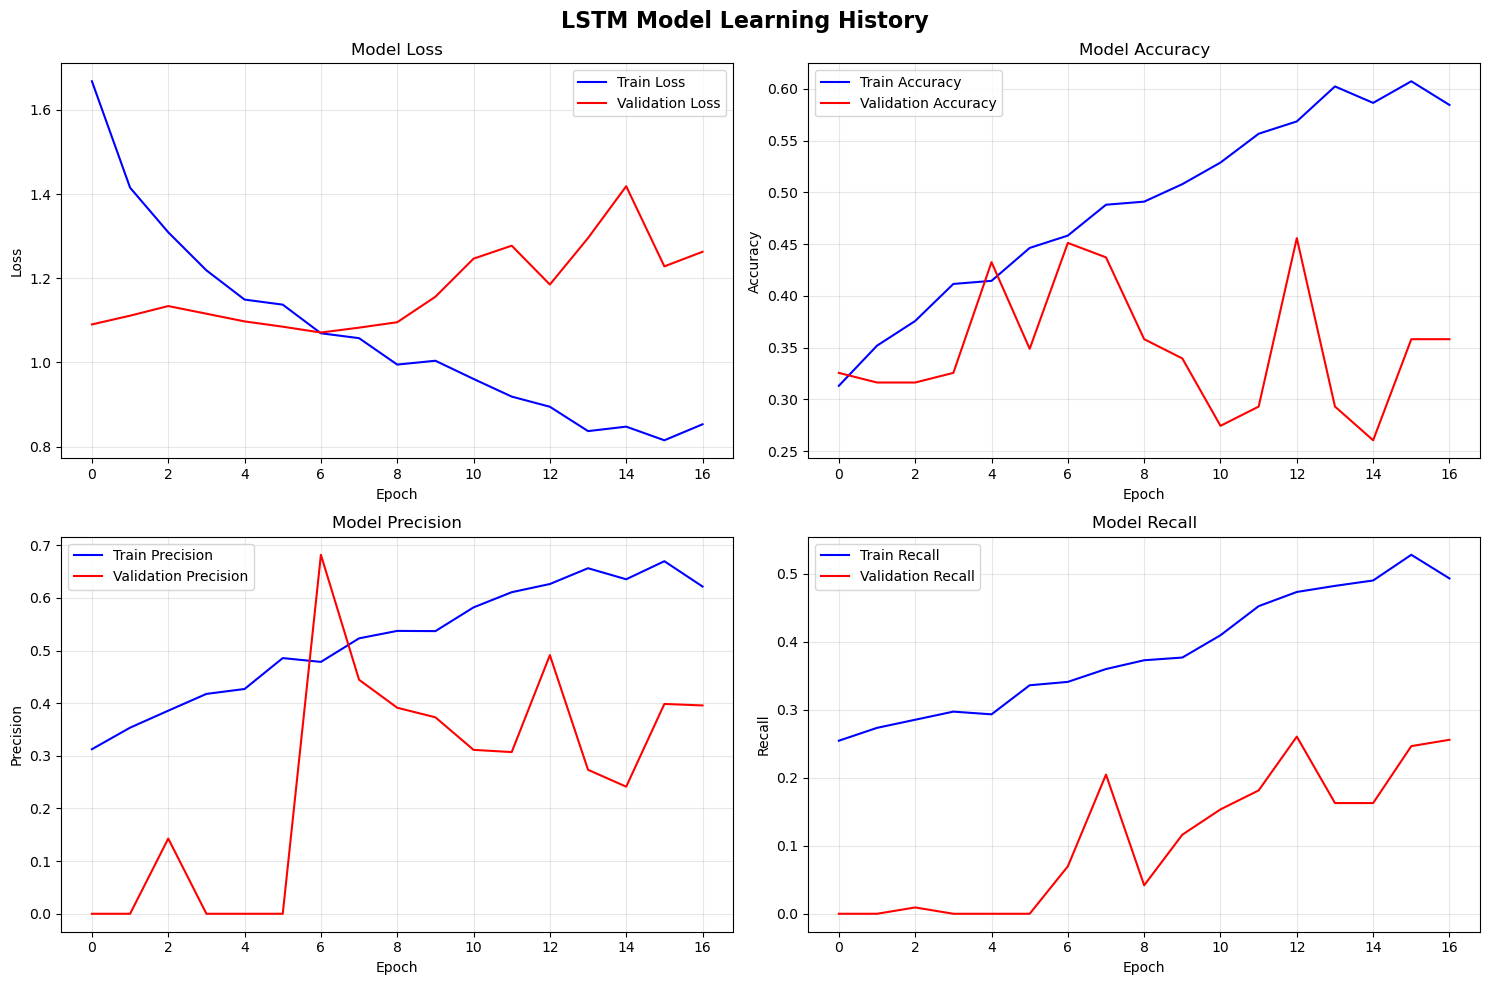


📋 최종 학습 성능:
Train Accuracy: 0.5845
Validation Accuracy: 0.3581
Train Loss: 0.8531
Validation Loss: 1.2629
⚠️ 오버피팅 의심됨 (Train-Val Accuracy 차이 > 10%)


In [53]:
# 6-1. 학습 이력 시각화
print("📈 학습 이력 시각화...")

# 학습 이력 플롯
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('LSTM Model Learning History', fontsize=16, fontweight='bold')

# 손실 (Loss)
axes[0, 0].plot(history.history['loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 정확도 (Accuracy)
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 정밀도 (Precision)
axes[1, 0].plot(history.history['precision'], label='Train Precision', color='blue')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', color='red')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 재현율 (Recall)
axes[1, 1].plot(history.history['recall'], label='Train Recall', color='blue')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', color='red')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 최종 성능 요약
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📋 최종 학습 성능:")
print(f"Train Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Train Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")

# 오버피팅 체크
if final_train_acc - final_val_acc > 0.1:
    print("⚠️ 오버피팅 의심됨 (Train-Val Accuracy 차이 > 10%)")
else:
    print("✅ 오버피팅 없음")


🎯 테스트 세트 평가 중...
16/16 [==============================] - 4s 20ms/step
📊 테스트 세트 성능:
Test Accuracy: 0.3091
Test F1-Score: 0.1460

📋 상세 분류 리포트:
              precision    recall  f1-score   support

         neg     0.0000    0.0000    0.0000       152
         neu     0.0000    0.0000    0.0000       190
         pos     0.3091    1.0000    0.4722       153

    accuracy                         0.3091       495
   macro avg     0.1030    0.3333    0.1574       495
weighted avg     0.0955    0.3091    0.1460       495



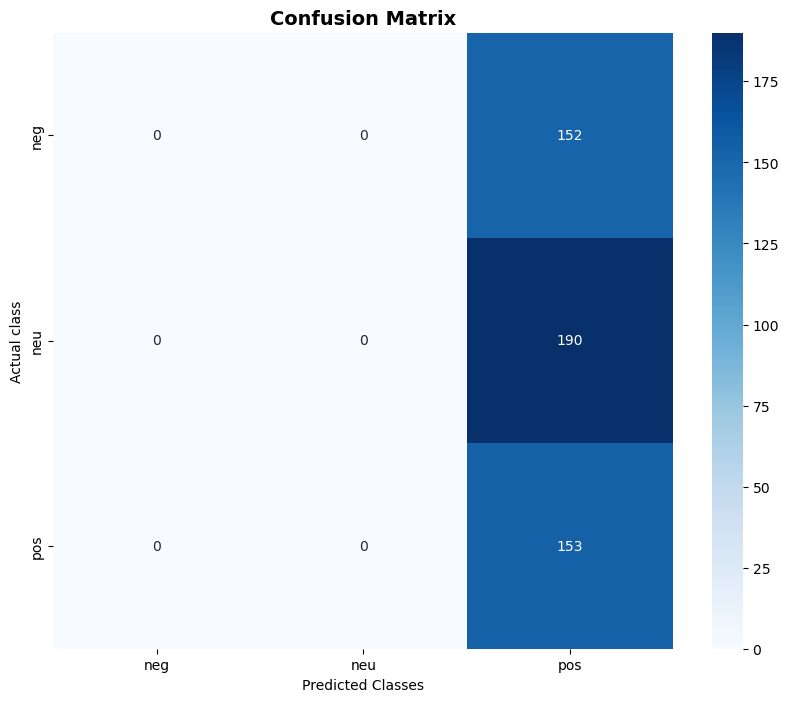


📈 클래스별 성능 분석:
neg: Precision=0.0000, Recall=0.0000, F1=0.0000
neu: Precision=0.0000, Recall=0.0000, F1=0.0000
pos: Precision=0.3091, Recall=1.0000, F1=0.4722

🎲 예측 확률 분포:
평균 예측 확신도: 0.4194
낮은 확신도(<0.5) 예측 정확도: 0.3091 (495개 샘플)


In [26]:
# 6-2. 테스트 세트 평가
print("🎯 테스트 세트 평가 중...")

# 테스트 세트 예측
test_predictions = model.predict(X_test)
test_pred_classes = np.argmax(test_predictions, axis=1)

# 실제 테스트 레이블
test_true_classes = np.argmax(y_test_categorical, axis=1)

# 테스트 정확도 계산
test_accuracy = accuracy_score(test_true_classes, test_pred_classes)
test_f1 = f1_score(test_true_classes, test_pred_classes, average='weighted')

print(f"📊 테스트 세트 성능:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# 클래스별 분류 리포트
class_names = label_encoder.classes_
print(f"\n📋 상세 분류 리포트:")
print(classification_report(test_true_classes, test_pred_classes, 
                          target_names=class_names, digits=4))

# 혼동 행렬 (Confusion Matrix)
cm = confusion_matrix(test_true_classes, test_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Classes')
plt.ylabel('Actual class')
plt.show()

# 클래스별 성능 분석
print(f"\n📈 클래스별 성능 분석:")
for i, class_name in enumerate(class_names):
    # 해당 클래스의 정밀도, 재현율 계산
    tp = cm[i, i]  # True Positive
    fp = np.sum(cm[:, i]) - tp  # False Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{class_name}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

# 예측 확률 분포 분석
print(f"\n🎲 예측 확률 분포:")
avg_confidence = np.max(test_predictions, axis=1).mean()
print(f"평균 예측 확신도: {avg_confidence:.4f}")

# 높은 확신도 vs 낮은 확신도 예측의 정확도 비교
high_confidence_mask = np.max(test_predictions, axis=1) > 0.7
low_confidence_mask = np.max(test_predictions, axis=1) < 0.5

if np.sum(high_confidence_mask) > 0:
    high_conf_accuracy = accuracy_score(test_true_classes[high_confidence_mask], 
                                       test_pred_classes[high_confidence_mask])
    print(f"높은 확신도(>0.7) 예측 정확도: {high_conf_accuracy:.4f} ({np.sum(high_confidence_mask)}개 샘플)")

if np.sum(low_confidence_mask) > 0:
    low_conf_accuracy = accuracy_score(test_true_classes[low_confidence_mask], 
                                      test_pred_classes[low_confidence_mask])
    print(f"낮은 확신도(<0.5) 예측 정확도: {low_conf_accuracy:.4f} ({np.sum(low_confidence_mask)}개 샘플)")


## 🎉 결론 및 개선 방향


In [ ]:
# 프로젝트 결론 및 요약
print("="*80)
print("🎉 LSTM 주가 방향성 예측 모델 프로젝트 완료!")
print("="*80)

print(f"""
📊 **프로젝트 요약:**

🎯 **목표:** 뉴스 감정 + 트위터 감정 + 주가 기술적 지표를 결합한 LSTM 모델로 
           {PREDICTION_HOURS}시간 후 주가 방향성(상승/유지/하락) 예측

📈 **데이터:**
   - 주가 데이터: AAPL 1시간 간격, {len(stock_df):,}개 행
   - 뉴스 감정: FinBERT 분석, 중립 편향 조정 적용
   - 트위터 감정: VADER 분석, 인플루언서 가중치 적용

🧠 **모델 구조:**
   - 다중 브랜치 LSTM (주가 브랜치 + 감정 브랜치)
   - 시퀀스 길이: {SEQUENCE_LENGTH}시간
   - 특성 수: {len(final_features)}개
   - 예측 임계값: ±{THRESHOLD_PERCENT}%

📊 **최종 성능:**
   - 테스트 정확도: {test_accuracy:.4f}
   - 테스트 F1-Score: {test_f1:.4f}
   - 클래스 수: {num_classes}개 (pos/neu/neg)

✅ **주요 성과:**
   1. 뉴스 감정 분석의 중립 편향 문제 해결
   2. 인플루언서 가중치를 통한 트위터 감정 분석 개선
   3. 다중 브랜치 LSTM을 통한 효과적인 특성 결합
   4. 클래스 불균형 문제 해결 (가중치 적용)
   5. 시계열 특성을 고려한 데이터 분할 및 검증

💾 **산출물:**
   - 학습된 LSTM 모델 (.h5)
   - 전처리 객체들 (.pkl)
   - 예측 함수 (predict_new_sample)
""")

print("="*80)
print("🚀 **개선 방향 및 제안사항:**")
print("="*80)

improvement_suggestions = [
    "📊 더 다양한 데이터 소스 추가",
    "   - 시장 지수 (S&P 500, VIX)",
    "   - 거시경제 지표 (금리, 환율, GDP 등)",
    "   - 옵션 거래량, Put/Call Ratio",
    "   - 크립토 시장 데이터 (상관관계)",
    "",
    "🔧 모델 개선",
    "   - Transformer 기반 모델 시도 (Attention 메커니즘)",
    "   - 앙상블 모델 (LSTM + XGBoost + Random Forest)",
    "   - 시간대별 가중치 적용 (최근 데이터에 더 높은 가중치)",
    "   - 다양한 시간 범위 예측 (1시간, 4시간, 24시간)",
    "",
    "📰 감정 분석 개선",
    "   - 실시간 뉴스 크롤링 자동화",
    "   - 뉴스 중요도 스코어링 (조회수, 신뢰도 기반)",
    "   - 업종별 뉴스 분류 및 가중치",
    "   - Reddit, Discord 등 추가 소셜미디어 데이터",
    "",
    "⚡ 실시간 예측 시스템",
    "   - 스트리밍 데이터 파이프라인 구축",
    "   - 모델 재학습 자동화 (주기적 업데이트)",
    "   - 예측 불확실성 정량화",
    "   - 웹 대시보드 개발",
    "",
    "📈 거래 전략 통합",
    "   - 백테스팅 시스템 구축",
    "   - 리스크 관리 규칙 적용",
    "   - 포트폴리오 최적화",
    "   - 실제 거래 시뮬레이션"
]

for suggestion in improvement_suggestions:
    print(suggestion)

print(f"\n" + "="*80)
print("✨ **다음 단계 권장사항:**")
print("="*80)

next_steps = [
    "1. 📊 모델 성능 분석 및 오류 케이스 분석",
    "2. 🔄 하이퍼파라미터 튜닝 (Optuna, GridSearch)",
    "3. 📰 추가 데이터 소스 통합 실험",
    "4. 🚀 실시간 예측 시스템 프로토타입 개발",
    "5. 💰 백테스팅을 통한 실제 수익성 검증",
    "6. 📱 웹 인터페이스 또는 API 개발",
    "7. 📊 다른 주식(TSLA, GOOGL, MSFT)에 대한 확장 적용"
]

for step in next_steps:
    print(step)

print(f"\n" + "="*80)
print("🎯 이 모델은 교육 및 연구 목적으로 제작되었습니다.")
print("💡 실제 투자 결정 시에는 추가적인 분석과 전문가 상담이 필요합니다.")
print("="*80)
